# 图像分类

在此项目中，你将对 [CIFAR-10 数据集](https://www.cs.toronto.edu/~kriz/cifar.html) 中的图片进行分类。该数据集包含飞机、猫狗和其他物体。

## 获取数据

下载 [CIFAR-10 数据集（Python版）](https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz)。


In [1]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm
import problem_unittests as tests
import tarfile

cifar10_dataset_folder_path = 'cifar-10-batches-py'

# Use Floyd's cifar-10 dataset if present
floyd_cifar10_location = '/input/cifar-10/python.tar.gz'
if isfile(floyd_cifar10_location):
    tar_gz_path = floyd_cifar10_location
else:
    tar_gz_path = 'cifar-10-python.tar.gz'

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile(tar_gz_path):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='CIFAR-10 Dataset') as pbar:
        urlretrieve(
            'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz',
            tar_gz_path,
            pbar.hook)

if not isdir(cifar10_dataset_folder_path):
    with tarfile.open(tar_gz_path) as tar:
        tar.extractall()
        tar.close()


tests.test_folder_path(cifar10_dataset_folder_path)

All files found!


## 探索数据

该数据集分成了几批次（batches），以免计算时内存不足。CIFAR-10 数据集包含 5 个部分，名称分别为 `data_batch_1`、`data_batch_2`，以此类推。每个部分都包含以下某个类别的标签和图片：

* 飞机
* 汽车
* 鸟类
* 猫
* 鹿
* 狗
* 青蛙
* 马
* 船只
* 卡车

可以通过更改 `batch_id` 和 `sample_id` 探索下面的代码单元。`batch_id` 是数据集一个部分的 ID（1 到 5）。`sample_id` 是该部分中图片和标签对（label pair）的 ID。


Stats of batch 5:
Samples: 10000
Label Counts: {0: 1014, 1: 1014, 2: 952, 3: 1016, 4: 997, 5: 1025, 6: 980, 7: 977, 8: 1003, 9: 1022}
First 20 Labels: [1, 8, 5, 1, 5, 7, 4, 3, 8, 2, 7, 2, 0, 1, 5, 9, 6, 2, 0, 8]

Example of Image 1000:
Image - Min Value: 28 Max Value: 228
Image - Shape: (32, 32, 3)
Label - Label Id: 7 Name: horse


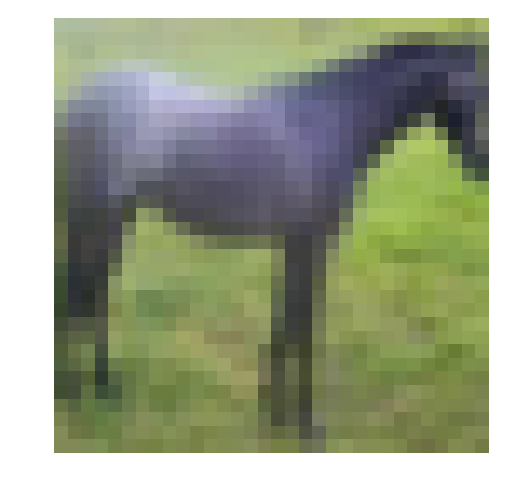

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import helper
import numpy as np


batch_id = 5
sample_id =1000
helper.display_stats(cifar10_dataset_folder_path, batch_id, sample_id)

## 实现预处理函数

### 标准化

实现 `normalize` 函数，传入图片数据 `x`，并返回标准化 Numpy 数组。值应该在 0 到 1 的范围内。返回对象应该和 `x` 的形状一样。


In [3]:
def normalize(x):
    """
    Normalize a list of sample image data in the range of 0 to 1
    : x: List of image data.  The image shape is (32, 32, 3)
    : return: Numpy array of normalize data
    """
    
    normalized_data = (x - np.min(x))/(np.max(x) - np.min(x))
    return normalized_data


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_normalize(normalize)

Tests Passed


### One-hot 编码

实现 `one_hot_encode` 函数，以返回为 one_hot 编码的 Numpy 数组的标签列表。标签的可能值为 0 到 9。每次调用 `one_hot_encode` 时，对于每个值，one_hot 编码函数应该返回相同的编码。

In [4]:
from sklearn import preprocessing
def one_hot_encode(x):
    """
    One hot encode a list of sample labels. Return a one-hot encoded vector for each label.
    : x: List of sample Labels
    : return: Numpy array of one-hot encoded labels
    """
    
    lb = preprocessing.LabelBinarizer()
    lb.fit(range(10))
    one_hot_labels = lb.transform(x)
    
    return one_hot_labels


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_one_hot_encode(one_hot_encode)

Tests Passed


### 随机化数据

样本的顺序是随机的,再随机化一次也不会有什么关系，但是对于这个数据集没有必要。


## 预处理所有数据并保存

运行下方的代码单元，将预处理所有 CIFAR-10 数据，并保存到文件中。下面的代码还使用了 10% 的训练数据，用来验证。


In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# Preprocess Training, Validation, and Testing Data
helper.preprocess_and_save_data(cifar10_dataset_folder_path, normalize, one_hot_encode)

# 检查点

In [2]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import pickle
import problem_unittests as tests
import helper

# Load the Preprocessed Validation data
valid_features, valid_labels = pickle.load(open('preprocess_validation.p', mode='rb'))

## 构建网络



### 输入

神经网络需要读取图片数据、one-hot 编码标签和丢弃保留概率（dropout keep probability）。实现以下函数：

* 实现 `neural_net_image_input`
 * 返回 [TF Placeholder](https://www.tensorflow.org/api_docs/python/tf/placeholder)
 * 使用 `image_shape` 设置形状，部分大小设为 `None`
 * 使用 [TF Placeholder](https://www.tensorflow.org/api_docs/python/tf/placeholder) 中的 TensorFlow `name` 参数对 TensorFlow 占位符 "x" 命名
* 实现 `neural_net_label_input`
 * 返回 [TF Placeholder](https://www.tensorflow.org/api_docs/python/tf/placeholder)
 * 使用 `n_classes` 设置形状，部分大小设为 `None`
 * 使用 [TF Placeholder](https://www.tensorflow.org/api_docs/python/tf/placeholder) 中的 TensorFlow `name` 参数对 TensorFlow 占位符 "y" 命名
* 实现 `neural_net_keep_prob_input`
 * 返回 [TF Placeholder](https://www.tensorflow.org/api_docs/python/tf/placeholder)，用于丢弃保留概率
 * 使用 [TF Placeholder](https://www.tensorflow.org/api_docs/python/tf/placeholder) 中的 TensorFlow `name` 参数对 TensorFlow 占位符 "keep_prob" 命名

这些名称将在项目结束时，用于加载保存的模型。

In [3]:
import tensorflow as tf

def neural_net_image_input(image_shape):
    """
    Return a Tensor for a batch of image input
    : image_shape: Shape of the images
    : return: Tensor for image input.
    """
   
    x = tf.placeholder(tf.float32 , shape=[None, image_shape[0], image_shape[1], image_shape[2]], name="x")
    return x


def neural_net_label_input(n_classes):
    """
    Return a Tensor for a batch of label input
    : n_classes: Number of classes
    : return: Tensor for label input.
    """
   
    y = tf.placeholder(tf.float32 , shape=[None, n_classes] , name="y")
    return y


def neural_net_keep_prob_input():
    """
    Return a Tensor for keep probability
    : return: Tensor for keep probability.
    """
    
    keep_prob = tf.placeholder(tf.float32 , name="keep_prob")
    return keep_prob


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tf.reset_default_graph()
tests.test_nn_image_inputs(neural_net_image_input)
tests.test_nn_label_inputs(neural_net_label_input)
tests.test_nn_keep_prob_inputs(neural_net_keep_prob_input)

Image Input Tests Passed.
Label Input Tests Passed.
Keep Prob Tests Passed.


### 卷积和最大池化层

卷积层级适合处理图片,实现函数 `conv2d_maxpool` 以便应用卷积然后进行最大池化：

* 使用 `conv_ksize`、`conv_num_outputs` 和 `x_tensor` 的形状创建权重（weight）和偏置（bias）。
* 使用权重和 `conv_strides` 对 `x_tensor` 应用卷积。
* 添加偏置
* 向卷积中添加非线性激活（nonlinear activation）
* 使用 `pool_ksize` 和 `pool_strides` 应用最大池化

In [42]:
def conv2d_maxpool(x_tensor, conv_num_outputs, conv_ksize, conv_strides, pool_ksize, pool_strides):
    """
    Apply convolution then max pooling to x_tensor
    :param x_tensor: TensorFlow Tensor
    :param conv_num_outputs: Number of outputs for the convolutional layer
    :param conv_ksize: kernal size 2-D Tuple for the convolutional layer
    :param conv_strides: Stride 2-D Tuple for convolution
    :param pool_ksize: kernal size 2-D Tuple for pool
    :param pool_strides: Stride 2-D Tuple for pool
    : return: A tensor that represents convolution and max pooling of x_tensor
    """
    
    
    #convolution
    weight = tf.Variable(tf.truncated_normal([conv_ksize[0],
                                              conv_ksize[1],
                                              x_tensor.get_shape().as_list()[3],
                                              conv_num_outputs], 
                                              stddev= 0.08))
    
    bias = tf.Variable(tf.zeros(conv_num_outputs))
    
    conv_layer = tf.nn.conv2d(x_tensor, weight, 
                              strides=[1, conv_strides[0], conv_strides[1], 1], padding='SAME')
    
    conv_layer = tf.nn.bias_add(conv_layer, bias)
    
    #max_pooling
    conv_layer = tf.nn.max_pool(conv_layer, 
                                ksize=[1, pool_ksize[0], pool_ksize[1], 1],
                                strides=[1, pool_strides[0], pool_strides[1], 1], 
                                padding='SAME')
    
    #activation
    conv_layer = tf.nn.elu(conv_layer)
    
    print (conv_layer.get_shape().as_list())
    return conv_layer 


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_con_pool(conv2d_maxpool)

[None, 4, 4, 10]
Tests Passed


### 扁平化层

实现 `flatten` 函数，将 `x_tensor` 的维度从四维张量（4-D tensor）变成二维张量。输出应该是形状（*部分大小（Batch Size）*，*扁平化图片大小（Flattened Image Size）*）。

In [43]:
def flatten(x_tensor):
    """
    Flatten x_tensor to (Batch Size, Flattened Image Size)
    : x_tensor: A tensor of size (Batch Size, ...), where ... are the image dimensions.
    : return: A tensor of size (Batch Size, Flattened Image Size).
    """
    
    
    x_flat = tf.reshape(x_tensor, 
                        [-1, x_tensor.get_shape().as_list()[1]*x_tensor.get_shape().as_list()[2]*x_tensor.get_shape().as_list()[3]])
        
    return x_flat


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_flatten(flatten)

Tests Passed


### 全连接层

实现 `fully_conn` 函数，以向 `x_tensor` 应用完全连接的层级，形状为（*部分大小（Batch Size）*，*num_outputs*）。

In [44]:
def fully_conn(x_tensor, num_outputs):
    """
    Apply a fully connected layer to x_tensor using weight and bias
    : x_tensor: A 2-D tensor where the first dimension is batch size.
    : num_outputs: The number of output that the new tensor should be.
    : return: A 2-D tensor where the second dimension is num_outputs.
    """
    
    
    weights = tf.Variable(tf.truncated_normal([x_tensor.get_shape().as_list()[1], num_outputs],
                                              stddev= 0.08))
               
    biases = tf.Variable(tf.zeros(num_outputs))
    
    keep_prob = tf.placeholder(tf.float32)
    
    hidden_layer = tf.add(tf.matmul(x_tensor, weights), biases)
    
    hidden_layer = tf.nn.elu(hidden_layer)
    
    hadden_layer = tf.nn.dropout(hidden_layer, keep_prob)
    
    return hidden_layer


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_fully_conn(fully_conn)

Tests Passed


### 输出层

实现 `output` 函数，向 x_tensor 应用完全连接的层级，形状为（*部分大小（Batch Size）*，*num_outputs*）。

In [45]:
def output(x_tensor, num_outputs):
    """
    Apply a output layer to x_tensor using weight and bias
    : x_tensor: A 2-D tensor where the first dimension is batch size.
    : num_outputs: The number of output that the new tensor should be.
    : return: A 2-D tensor where the second dimension is num_outputs.
    """
    
    weights = tf.Variable(tf.random_normal([x_tensor.get_shape().as_list()[1], num_outputs],
                                           stddev= 0.08))
               
    biases = tf.Variable(tf.zeros([num_outputs]))
    
    output = tf.add(tf.matmul(x_tensor, weights), biases)
    
    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_output(output)

Tests Passed


### 创建卷积模型

实现函数 `conv_net`， 创建卷积神经网络模型。该函数传入一批图片 `x`，并输出对数（logits）。使用在前面创建的层创建此模型：

* 应用 1、2 或 3 个卷积和最大池化层（Convolution and Max Pool layers）
* 应用一个扁平层（Flatten Layer）
* 应用 1、2 或 3 个完全连接层（Fully Connected Layers）
* 应用一个输出层（Output Layer）
* 返回输出
* 使用 `keep_prob` 向模型中的一个或多个层应用 [TensorFlow 的 Dropout](https://www.tensorflow.org/api_docs/python/tf/nn/dropout)

In [46]:
def conv_net(x, keep_prob):
    """
    Create a convolutional neural network model
    : x: Placeholder tensor that holds image data.
    : keep_prob: Placeholder tensor that hold dropout keep probability.
    : return: Tensor that represents logits
    """
    # conv2d_maxpool(x_tensor, conv_num_outputs, conv_ksize, conv_strides, pool_ksize, pool_strides)
    
    conv_num_outputs = 32
    conv_ksize = (3, 3)
    conv_strides = (1, 1)
    pool_ksize = (3, 3)
    pool_strides = (2, 2)
    conv_x = conv2d_maxpool(x, conv_num_outputs, conv_ksize, conv_strides, pool_ksize, pool_strides)
    print (conv_x.get_shape().as_list())
    
    
    conv_num_outputs = 64
    conv_ksize = (3, 3)
    conv_strides = (1, 1)
    pool_ksize = (3, 3)
    pool_strides = (2, 2)
    conv_x = conv2d_maxpool(conv_x, conv_num_outputs, conv_ksize, conv_strides, pool_ksize, pool_strides)
    print (conv_x.get_shape().as_list())
    
    
    """
    conv_num_outputs = 128
    conv_ksize = (3,3)
    conv_strides = (1, 1)
    pool_ksize = (3, 3)
    pool_strides = (2, 2)
    conv_x = conv2d_maxpool(conv_x, conv_num_outputs, conv_ksize, conv_strides, pool_ksize, pool_strides)
    print (conv_x.get_shape().as_list())
    """
    

    # flatten(x_tensor)
    flatten_x = flatten(conv_x)
    

    # fully_conn(x_tensor, num_outputs)
    hidden_layer1 = fully_conn(flatten_x, 1024)
    
    hidden_layer2 = fully_conn(hidden_layer1, 512)
    
    hidden_layer3 = fully_conn(hidden_layer2, 256)
    
    
    # output(x_tensor, num_outputs)
    
    out = output(hidden_layer3, 10)
    
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""

##############################
## Build the Neural Network ##
##############################

# Remove previous weights, bias, inputs, etc..
tf.reset_default_graph()

# Inputs
x = neural_net_image_input((32, 32, 3))
y = neural_net_label_input(10)
keep_prob = neural_net_keep_prob_input()

# Model
logits = conv_net(x, keep_prob)

# Name logits Tensor, so that is can be loaded from disk after training
logits = tf.identity(logits, name='logits')

# Loss and Optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))
optimizer = tf.train.AdamOptimizer().minimize(cost)

# Accuracy
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

tests.test_conv_net(conv_net)

[None, 16, 16, 32]
[None, 16, 16, 32]
[None, 8, 8, 64]
[None, 8, 8, 64]
[None, 16, 16, 32]
[None, 16, 16, 32]
[None, 8, 8, 64]
[None, 8, 8, 64]
Neural Network Built!


## 训练神经网络

### 单次优化

实现函数 `train_neural_network` 以进行单次优化（single optimization）。该优化应该使用 `optimizer` 优化 `session`，其中 `feed_dict` 具有以下参数：

* `x` 表示图片输入
* `y` 表示标签
* `keep_prob` 表示丢弃的保留率

In [47]:
def train_neural_network(session, optimizer, keep_probability, feature_batch, label_batch):
    """
    Optimize the session on a batch of images and labels
    : session: Current TensorFlow session
    : optimizer: TensorFlow optimizer function
    : keep_probability: keep probability
    : feature_batch: Batch of Numpy image data
    : label_batch: Batch of Numpy label data
    """
    
    session.run(optimizer, feed_dict={x:feature_batch, y:label_batch, keep_prob:keep_probability})


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_train_nn(train_neural_network)

Tests Passed


### 显示数据

实现函数 `print_stats` 以输出损失和验证准确率。使用全局变量 `valid_features` 和 `valid_labels` 计算验证准确率。使用保留率 `1.0` 计算损失和验证准确率（loss and validation accuracy）。


In [48]:
def print_stats(session, feature_batch, label_batch, cost, accuracy):
    """
    Print information about loss and validation accuracy
    : session: Current TensorFlow session
    : feature_batch: Batch of Numpy image data
    : label_batch: Batch of Numpy label data
    : cost: TensorFlow cost function
    : accuracy: TensorFlow accuracy function
    """

    current_cost = sess.run(cost,
                            feed_dict={x: feature_batch, y: label_batch, keep_prob: 1})
    valid_accuracy = sess.run(accuracy,
                              feed_dict={x: valid_features, y: valid_labels, keep_prob: 1})
    print('Loss: {} Valid Accuracy: {}'.format(current_cost, valid_accuracy))

### 超参数

调试以下超参数：
* 设置 `epochs` 表示神经网络停止学习或开始过拟合的迭代次数
* 设置 `batch_size`，表示机器内存允许的部分最大体积。大部分人设为以下常见内存大小：

 * 64
 * 128
 * 256
 * ...
* 设置 `keep_probability` 表示使用丢弃时保留节点的概率

In [53]:
epochs = 15
batch_size = 256
keep_probability = 0.5

### 在单个 CIFAR-10 部分上训练

先用单个部分，而不是用所有的 CIFAR-10 批次训练神经网络。这样可以节省时间，并对模型进行迭代，以提高准确率。验证准确率达到 50% 或以上之后，在下一部分对所有数据运行模型。

In [56]:
print('Checking the Training on a Single Batch...')
with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    for epoch in range(epochs):
        batch_i = 1
        for batch_features, batch_labels in helper.load_preprocess_training_batch(batch_i, batch_size):
            train_neural_network(sess, optimizer, keep_probability, batch_features, batch_labels)
        print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
        print_stats(sess, batch_features, batch_labels, cost, accuracy)

Checking the Training on a Single Batch...
Epoch  1, CIFAR-10 Batch 1:  Loss: 1.6458909511566162 Valid Accuracy: 0.41440001130104065
Epoch  2, CIFAR-10 Batch 1:  Loss: 1.113774061203003 Valid Accuracy: 0.5005999803543091
Epoch  3, CIFAR-10 Batch 1:  Loss: 0.7932953238487244 Valid Accuracy: 0.5138000249862671
Epoch  4, CIFAR-10 Batch 1:  Loss: 0.5773025155067444 Valid Accuracy: 0.5508000254631042
Epoch  5, CIFAR-10 Batch 1:  Loss: 0.4070081114768982 Valid Accuracy: 0.5618000030517578
Epoch  6, CIFAR-10 Batch 1:  Loss: 0.27223721146583557 Valid Accuracy: 0.5681999921798706
Epoch  7, CIFAR-10 Batch 1:  Loss: 0.19416075944900513 Valid Accuracy: 0.5562000274658203
Epoch  8, CIFAR-10 Batch 1:  Loss: 0.10097496211528778 Valid Accuracy: 0.5885999798774719
Epoch  9, CIFAR-10 Batch 1:  Loss: 0.0867920070886612 Valid Accuracy: 0.5885999798774719
Epoch 10, CIFAR-10 Batch 1:  Loss: 0.07023108750581741 Valid Accuracy: 0.5928000211715698
Epoch 11, CIFAR-10 Batch 1:  Loss: 0.07009977102279663 Valid Ac

### 完全训练模型

试试所有五个部分。

In [54]:
save_model_path = './image_classification'

print('Training...')
with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    # Training cycle
    for epoch in range(epochs):
        # Loop over all batches
        n_batches = 5
        for batch_i in range(1, n_batches + 1):
            for batch_features, batch_labels in helper.load_preprocess_training_batch(batch_i, batch_size):
                train_neural_network(sess, optimizer, keep_probability, batch_features, batch_labels)
            print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
            print_stats(sess, batch_features, batch_labels, cost, accuracy)
            
    # Save Model
    saver = tf.train.Saver()
    save_path = saver.save(sess, save_model_path)

Training...
Epoch  1, CIFAR-10 Batch 1:  Loss: 1.760672926902771 Valid Accuracy: 0.39259999990463257
Epoch  1, CIFAR-10 Batch 2:  Loss: 1.3661839962005615 Valid Accuracy: 0.4909999966621399
Epoch  1, CIFAR-10 Batch 3:  Loss: 1.044635534286499 Valid Accuracy: 0.5194000005722046
Epoch  1, CIFAR-10 Batch 4:  Loss: 1.0430272817611694 Valid Accuracy: 0.5590000152587891
Epoch  1, CIFAR-10 Batch 5:  Loss: 1.0577385425567627 Valid Accuracy: 0.5917999744415283
Epoch  2, CIFAR-10 Batch 1:  Loss: 0.962519645690918 Valid Accuracy: 0.5712000131607056
Epoch  2, CIFAR-10 Batch 2:  Loss: 0.7451847791671753 Valid Accuracy: 0.6208000183105469
Epoch  2, CIFAR-10 Batch 3:  Loss: 0.5331921577453613 Valid Accuracy: 0.633400022983551
Epoch  2, CIFAR-10 Batch 4:  Loss: 0.5552451014518738 Valid Accuracy: 0.629800021648407
Epoch  2, CIFAR-10 Batch 5:  Loss: 0.5865290760993958 Valid Accuracy: 0.6304000020027161
Epoch  3, CIFAR-10 Batch 1:  Loss: 0.5393936634063721 Valid Accuracy: 0.6466000080108643
Epoch  3, CIF

# 检查点

模型已保存到本地。

## 测试模型

利用测试数据集测试你的模型。

Testing Accuracy: 0.70234375



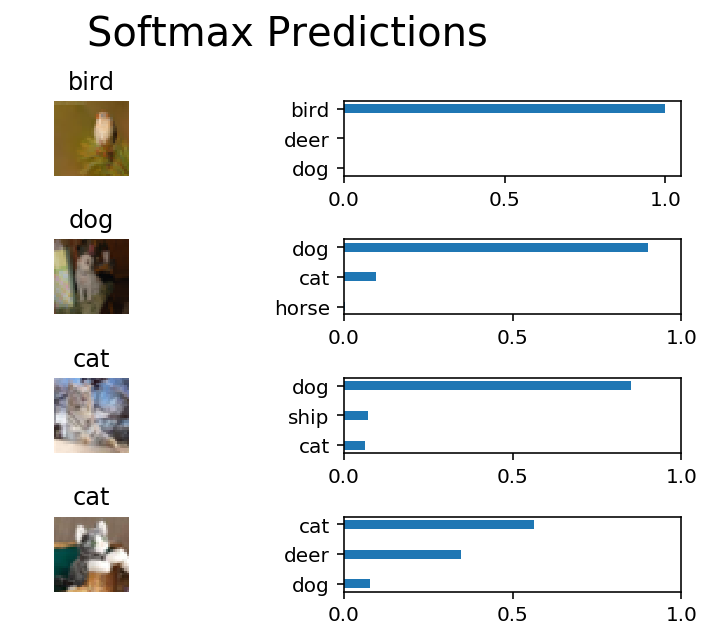

In [55]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import tensorflow as tf
import pickle
import helper
import random

# Set batch size if not already set
try:
    if batch_size:
        pass
except NameError:
    batch_size = 64

save_model_path = './image_classification'
n_samples = 4
top_n_predictions = 3

def test_model():
    """
    Test the saved model against the test dataset
    """

    test_features, test_labels = pickle.load(open('preprocess_test.p', mode='rb'))
    loaded_graph = tf.Graph()

    with tf.Session(graph=loaded_graph) as sess:
        # Load model
        loader = tf.train.import_meta_graph(save_model_path + '.meta')
        loader.restore(sess, save_model_path)

        # Get Tensors from loaded model
        loaded_x = loaded_graph.get_tensor_by_name('x:0')
        loaded_y = loaded_graph.get_tensor_by_name('y:0')
        loaded_keep_prob = loaded_graph.get_tensor_by_name('keep_prob:0')
        loaded_logits = loaded_graph.get_tensor_by_name('logits:0')
        loaded_acc = loaded_graph.get_tensor_by_name('accuracy:0')
        
        # Get accuracy in batches for memory limitations
        test_batch_acc_total = 0
        test_batch_count = 0
        
        for test_feature_batch, test_label_batch in helper.batch_features_labels(test_features, test_labels, batch_size):
            test_batch_acc_total += sess.run(
                loaded_acc,
                feed_dict={loaded_x: test_feature_batch, loaded_y: test_label_batch, loaded_keep_prob: 1.0})
            test_batch_count += 1

        print('Testing Accuracy: {}\n'.format(test_batch_acc_total/test_batch_count))

        # Print Random Samples
        random_test_features, random_test_labels = tuple(zip(*random.sample(list(zip(test_features, test_labels)), n_samples)))
        random_test_predictions = sess.run(
            tf.nn.top_k(tf.nn.softmax(loaded_logits), top_n_predictions),
            feed_dict={loaded_x: random_test_features, loaded_y: random_test_labels, loaded_keep_prob: 1.0})
        helper.display_image_predictions(random_test_features, random_test_labels, random_test_predictions)


test_model()

## 为何准确率只有70%？

对于简单的 CNN 网络来说，50% 已经不低了。纯粹猜测的准确率为10%。但是，你可能注意到有的准确率[远远超过 80%](http://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html#43494641522d3130)。这是因为此项目还未应用到所有的神经网络知识和技巧。